The iPython notebook scrapes the PMF webpage that lists the current Finalists. It then appends the appointment data from that scrape to a csv file of the Finalists that is used to track appointments over time. The resulting number of appointed PMFs is then displayed in a simple plot.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from datetime import timedelta #for accurate plotting of dates%matplotlib inline
from datetime import datetime
from bs4 import BeautifulSoup
from urllib.request import urlopen

In [2]:
df=pd.read_csv('2017_Appointments.csv',encoding = "ISO-8859-1")

This next block opens the webpage of 2017 finalists, locates the table of the finalists in the html, and for each finalists, records if they have an appointment in the dataframe df.

In [4]:
url='https://apply.pmf.gov/finalists.aspx' #url of pmf finalist webpage
html = urlopen(url); #using simple urlopen package to download webpage
bsObj = BeautifulSoup(html.read(), 'lxml'); #using BeautifulSoup to decode webpage
#this section pulls the date from the downloaded page, to be used when appending appointment record to csv file
a=bsObj.find(id='container_date').text.replace('\xa0','')
b=datetime.strptime(a,'%A, %B %d, %Y')
date=b.strftime('%y%m%d')
#this section finds the table of finalists, then the Status column and
#appends appointment status to csv file using Finalists' names as a key.
bsObj_table=bsObj.find('table',id="dataTable");
bsObj_finalists=bsObj_table.find_all('tr');
for x in range(0,len(bsObj_finalists)):
    try:
        df.loc[df.loc[:,'Name']==bsObj_finalists[x].find_all('td')[1].text,'Status_%s'%(date)]=int(
            bsObj_finalists[x].find_all('td')[5].text.replace('-','0').replace('Appointed','1'))
    except:
        df.loc[df.loc[:,'Name']==bsObj_finalists[x].find_all('td')[1].text,'Status_%s'%(date)]=np.nan

A simple plot of the number of appointed 2017 Finalists. (170325 crafted from memory. Might be off by a day or an appointment.)


In [5]:
df.iloc[:,-1].isnull().sum()

8

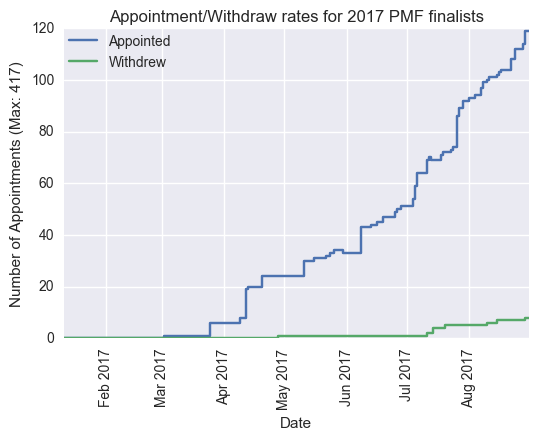

In [6]:
date=[];
count=[];
withdraw=[];
z=df.columns[df.columns.str.contains('Status')];
for x in range(0,len(z)):
    date.append(datetime.strptime(z[x][-6:],"%y%m%d"))
    try:
        count.append(df.loc[:,z[x]].value_counts()[1])
    except:
        count.append(0)
    withdraw.append(df.loc[:,z[x]].isnull().sum())
plt.step(date,count,label='Appointed');
plt.step(date,withdraw,label='Withdrew');
plt.title('Appointment/Withdraw rates for 2017 PMF finalists');
plt.ylabel('Number of Appointments (Max: 417)');
plt.xlabel('Date');
plt.xticks(rotation=90);
plt.legend(bbox_to_anchor=(.0, 1),loc=2,borderaxespad=0.);
plt.savefig('AppointmentRates2017.png',bbox_inches='tight')

In [7]:
df.columns[-1]

'Status_170831'

Saving the newly appended csv file.

In [8]:
df.to_csv('2017_Appointments.csv',index=False)

Current percent of 2017 Finalists listed as appointed:

In [9]:
print('%s 2017 Fellows'% (round(df.iloc[:,-1].sum())))
print("%s percent of active Finalists appointed"% (round((df.iloc[:,-1].sum()/len(df.iloc[:,-1].dropna())*100),1)))

119 2017 Fellows
29.1 percent of active Finalists appointed


In [10]:
date=[];
count=[];
withdraw=[];
z=df.columns[df.columns.str.contains('Status')];
for x in range(0,len(z)):
    date.append(datetime.strptime(z[x][-6:],"%y%m%d"))
    try:
        count.append(df.loc[:,z[x]].value_counts()[1])
    except:
        count.append(0)
    withdraw.append(df.loc[:,z[x]].isnull().sum())
df_rate=pd.DataFrame();
df_rate['date']=date;
df_rate['count']=count;
df_rate['days']=(df_rate['date']-date[0]).dt.days;

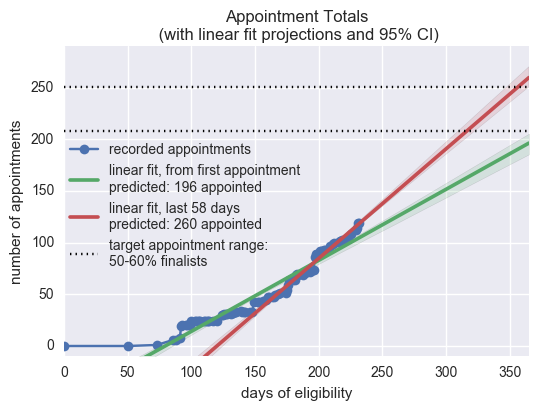

In [11]:
plt.xlim([0,365])
plt.plot(df_rate['days'].values, df_rate['count'].values,marker='o',label='recorded appointments');
#i=0
#sns.regplot(df_rate['days'].values[i:], df_rate['count'].values[i:],scatter=False,ci=95,order=1,
#            label='linear fit, from first day')
i=1
z=np.polyfit(df_rate['days'].values[i:], df_rate['count'].values[i:], 1);
p = np.poly1d(z);
p1=sns.regplot(df_rate['days'].values[i:], df_rate['count'].values[i:],scatter=False,ci=95,order=1,
            label='linear fit, from first appointment\npredicted: %s appointed'%(np.int(np.round(p(365)))))

i=df_rate.loc[df_rate['date']>(date[-1]-timedelta(days=60)),:].index[0];
z=np.polyfit(df_rate['days'].values[i:], df_rate['count'].values[i:], 1);
p = np.poly1d(z);
p2=sns.regplot(df_rate['days'].values[i:], df_rate['count'].values[i:],scatter=False,ci=95,order=1,
            label='linear fit, last %s days\npredicted: %s appointed'%(
        df_rate.loc[len(df_rate)-1,'days']-df_rate.loc[i,'days'],np.int(np.round(p(365)))))
plt.xlim([0,365])
plt.ylim([-10,290])
plt.axhline(417*.5,color='black',linestyle=':',label='target appointment range:\n50-60% finalists');
plt.axhline(417*.6,color='black',linestyle=':');
plt.legend(bbox_to_anchor=(.55, .75),loc=1,borderaxespad=1.);
plt.xlabel('days of eligibility');
plt.ylabel('number of appointments');
plt.title('Appointment Totals\n (with linear fit projections and 95% CI)');
#plt.savefig('AppointmentProjections2017.png',bbox_inches='tight')

Removing some redundant recordings. If a recording is the same as the recordings taken before and after, it will be dropped from the list that is uploaded to GitHub.

In [ ]:
#names=df.loc[df.fillna(-1).iloc[:,-1]!=df.fillna(-1).iloc[:,-2],'Name'].values

In [12]:
repeats=[]
for x in range(1,len(df.columns)-1):
    if ((df.iloc[:,x]==df.iloc[:,x-1]).all())&((df.iloc[:,x]==df.iloc[:,x+1]).all()):
        repeats.append(x)
df.drop(df.columns[repeats],axis=1,inplace=True)
df.drop('Name',axis=1,inplace=True)
df.to_csv('Appointments2017-GitHub.csv',index=False)

At some point during the eligibility year (I noticed on 5/26/2017), the PMF office added another feature to the finalist webpage. A tab on the displayed table to one of all the 2017 PMF that have been appointed and the agencies which they joined. This seemed like important information, so I've decided to try to collect it as well.

In [13]:
bsObj_table2=bsObj.find(id="divAppointed")
bsObj_appointments=bsObj_table2.find_all('tr');
df_appointments=pd.DataFrame(columns=['Agency/Sub-Agency','Class','Name','Start Date'])
columns=list(df_appointments.columns)
for x in range(0,len(bsObj_appointments)):
    for y in range(0,len(df_appointments.columns)):
        df_appointments.loc[x,columns[y]]=str(bsObj_appointments[x].find_all('td')[y]).replace('<td>','').replace('</td>','').replace('&amp;','and')

In [14]:
date=b.strftime('%y%m%d')
date

'170831'

In [15]:
df_appointments.to_csv('appointmentAgencies_%s.csv'%(date),index=False)

In [16]:
del df_appointments['Name']

In [17]:
df_appointments.to_csv('appointmentAgencies-GitHub.csv',index=False)

In [18]:
#df_appointments.loc[df_appointments.loc[:,'Name'].isin(names),:]

In [19]:
df_appointments.sample(4)

,Agency/Sub-Agency,Class,Start Date
30,Department of Health and Human Services / Nati...,2017,
107,Department of Veterans Affairs / Veterans Heal...,2017,6/11/2017
81,Department of Agriculture / Natural Resources ...,2017,5/28/2017
26,Department of Health and Human Services / Nati...,2017,


In [20]:
df_rate.tail(1)['days'].values[0]

232

In [21]:
df_rate2=pd.DataFrame();
df_rate2['days']=range(0,df_rate.tail(1)['days'].values[0]+1);
df_rate2['count']=0;
for x in range(0,len(df_rate)):
    df_rate2.loc[df_rate2.loc[:,'days']==df_rate.loc[x,'days'],'count']=df_rate.loc[x,'count'];
for x in range(1, len(df_rate2)):
    if df_rate2.loc[x,'count']==0:
        df_rate2.loc[x,'count']=df_rate2.loc[x-1,'count']

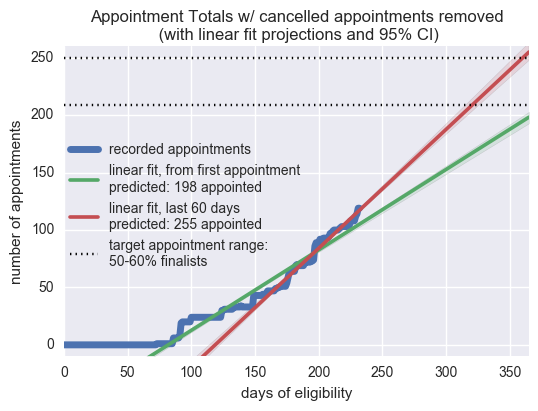

In [33]:
plt.xlim([0,365])
plt.plot(df_rate2['days'].values, df_rate2['count'].values,linewidth=5,
         label='recorded appointments');
i=df_rate2.loc[df_rate2.loc[:,'count']>0,'days'].values[0]
z=np.polyfit(df_rate2['days'].values[i:], df_rate2['count'].values[i:], 1);
p = np.poly1d(z);
p1=sns.regplot(df_rate2['days'].values[i:], df_rate2['count'].values[i:],scatter=False,ci=95,order=1,
            label='linear fit, from first appointment\npredicted: %s appointed'%(np.int(np.round(p(365)))))

i=(df_rate2.tail(1)['days']-60).values[0]
z=np.polyfit(df_rate2['days'].values[i:], df_rate2['count'].values[i:], 1);
p = np.poly1d(z);
p2=sns.regplot(df_rate2['days'].values[i:], df_rate2['count'].values[i:],scatter=False,ci=95,order=1,
            label='linear fit, last 60 days\npredicted: %s appointed'%(np.int(np.round(p(365)))))
plt.xlim([0,365])
plt.ylim([-10,260])
plt.axhline(417*.5,color='black',linestyle=':',label='target appointment range:\n50-60% finalists');
plt.axhline(417*.6,color='black',linestyle=':');
plt.legend(bbox_to_anchor=(.55, .75),loc=1,borderaxespad=1.);
plt.xlabel('days of eligibility');
plt.ylabel('number of appointments');
plt.title('Appointment Totals w/ cancelled appointments removed\n (with linear fit projections and 95% CI)');
plt.savefig('AppointmentProjections2017.png',bbox_inches='tight')

In [23]:
df_rate3=df_rate2.copy()

In [24]:
df=pd.read_csv('2017_Appointments.csv',encoding = "ISO-8859-1")

In [25]:
df_appointments=pd.read_csv('appointmentAgencies_170731.csv')

In [26]:
unfortunates=df_appointments.loc[(df_appointments.loc[:,'Agency/Sub-Agency']=='Department of State')&(
        df_appointments.loc[:,'Start Date'].isnull()),'Name'].values

In [27]:
df.ix[df.loc[:,'Name'].isin(unfortunates),5:]=0

In [28]:
date=[];
count=[];
withdraw=[];
z=df.columns[df.columns.str.contains('Status')];
for x in range(0,len(z)):
    date.append(datetime.strptime(z[x][-6:],"%y%m%d"))
    try:
        count.append(df.loc[:,z[x]].value_counts()[1])
    except:
        count.append(0)
    withdraw.append(df.loc[:,z[x]].isnull().sum())
df_rate=pd.DataFrame();
df_rate['date']=date;
df_rate['count']=count;
df_rate['days']=(df_rate['date']-date[0]).dt.days;

In [29]:
df_rate2=pd.DataFrame();
df_rate2['days']=range(0,df_rate.tail(1)['days'].values[0]+1);
df_rate2['count']=0;
for x in range(0,len(df_rate)):
    df_rate2.loc[df_rate2.loc[:,'days']==df_rate.loc[x,'days'],'count']=df_rate.loc[x,'count'];
for x in range(1, len(df_rate2)):
    if df_rate2.loc[x,'count']==0:
        df_rate2.loc[x,'count']=df_rate2.loc[x-1,'count']

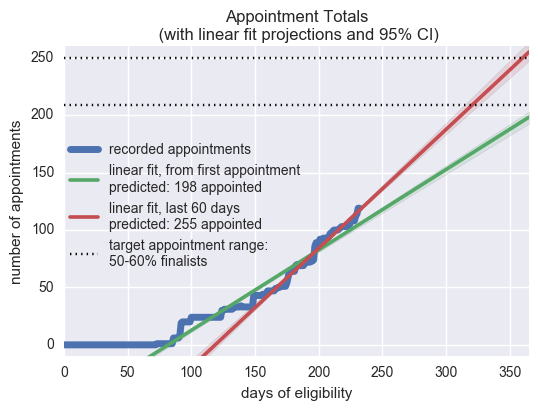

In [30]:
plt.xlim([0,365])
plt.plot(df_rate2['days'].values, df_rate2['count'].values,linewidth=5,
         label='recorded appointments');
i=df_rate2.loc[df_rate2.loc[:,'count']>0,'days'].values[0]
z=np.polyfit(df_rate2['days'].values[i:], df_rate2['count'].values[i:], 1);
p = np.poly1d(z);
p1=sns.regplot(df_rate2['days'].values[i:], df_rate2['count'].values[i:],scatter=False,ci=95,order=1,
            label='linear fit, from first appointment\npredicted: %s appointed'%(np.int(np.round(p(365)))))

i=(df_rate2.tail(1)['days']-60).values[0]
z=np.polyfit(df_rate2['days'].values[i:], df_rate2['count'].values[i:], 1);
p = np.poly1d(z);
p2=sns.regplot(df_rate2['days'].values[i:], df_rate2['count'].values[i:],scatter=False,ci=95,order=1,
            label='linear fit, last 60 days\npredicted: %s appointed'%(np.int(np.round(p(365)))))
plt.xlim([0,365])
plt.ylim([-10,260])
plt.axhline(417*.5,color='black',linestyle=':',label='target appointment range:\n50-60% finalists');
plt.axhline(417*.6,color='black',linestyle=':');
plt.legend(bbox_to_anchor=(.55, .75),loc=1,borderaxespad=1.);
plt.xlabel('days of eligibility');
plt.ylabel('number of appointments');
plt.title('Appointment Totals\n (with linear fit projections and 95% CI)');

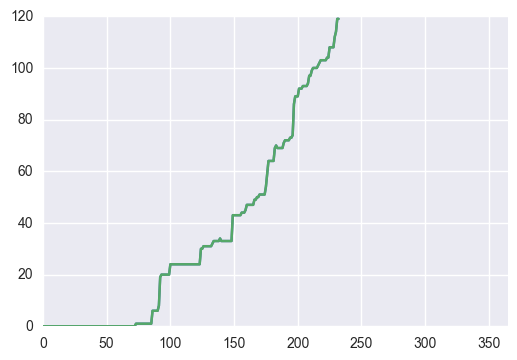

In [31]:
plt.xlim([0,365])
plt.plot(df_rate2['days'].values, df_rate2['count'].values,
         label='recorded appointments');
plt.plot(df_rate3['days'].values, df_rate3['count'].values,
         label='recorded appointments');

In [32]:
#unfortunates